In [1]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [2]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [3]:
sqlContext = SQLContext(sc)

In [8]:
from pyspark.sql.functions import udf
import string
import re
from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml import Pipeline, PipelineModel

In [7]:
# review_raw = spark.read.json("/Users/Grace/desktop/msan/msan697/dataset/review.json")

In [4]:
review_raw =spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri","mongodb://ec2-34-216-224-27.us-west-2.compute.amazonaws.com/project.review").load()

In [5]:
review = review_raw.select('text','stars')
review_sub = review.sample(False, 0.01, 1)
review_neg = review_sub.filter("stars<3").select("text")
review_pos = review_sub.filter("stars>=4").select("text")

In [9]:
def remove_num_punct(text):
    text = text.lower()
    my_string = text.replace("-", " ")
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", my_string)  # delete stuff but leave at least a space to avoid clumping together
    return nopunct

udf_num_punct = udf(lambda x:remove_num_punct(x))

In [10]:
def bi_gram(words):
    words = [w for w in words if len(w) > 0]
    bigram = [" ".join([words[i],words[i+1]])for i in range(len(words)-1)]
    return bigram

In [11]:
def tri_gram(words):
    words = [w for w in words if len(w) > 0]
    trigram = [" ".join([words[i],words[i+1],words[i+2]])for i in range(len(words)-2)]
    return trigram

In [12]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered", caseSensitive=False)
pipeline=Pipeline(stages=[tokenizer,remover])

## Positive Review

In [13]:
review_pos = review_pos.select(udf_num_punct('text').alias('text'))
pos_words=pipeline.fit(review_pos).transform(review_pos).select("filtered")
pos_rdd= pos_words.rdd.map(list).map(lambda x:x[0]).cache()

In [14]:
pos_uni=pos_rdd.flatMap(lambda words: [w for w in words if len(w) > 0])
top_pos_uni = pos_uni.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_pos_uni.collect()[0:20]

[(u'great', 17066),
 (u'place', 15369),
 (u'good', 15328),
 (u'food', 14144),
 (u'service', 9986),
 (u'like', 9677),
 (u'time', 9632),
 (u'one', 9066),
 (u'get', 8866),
 (u'really', 8094),
 (u'go', 7951),
 (u'back', 7839),
 (u'also', 7211),
 (u'best', 6758),
 (u've', 6571),
 (u'love', 6468),
 (u'nice', 6095),
 (u'always', 6061),
 (u'well', 5709),
 (u'friendly', 5481)]

In [15]:
pos_bi= pos_rdd.flatMap(lambda x: bi_gram(x))
top_pos_bi = pos_bi.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_pos_bi.collect()[0:20]

[(u'highly recommend', 1570),
 (u'first time', 1277),
 (u'customer service', 1202),
 (u'really good', 1171),
 (u'go back', 1094),
 (u'come back', 1079),
 (u'las vegas', 1014),
 (u'great service', 979),
 (u'great place', 935),
 (u'love place', 904),
 (u'next time', 870),
 (u'ice cream', 850),
 (u've ever', 835),
 (u'great food', 830),
 (u'food great', 772),
 (u'make sure', 748),
 (u'service great', 747),
 (u'one best', 736),
 (u'every time', 729),
 (u'pretty good', 705)]

In [16]:
pos_tri= pos_rdd.flatMap(lambda x: tri_gram(x))
top_pos_tri = pos_tri.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_pos_tri.collect()[0:20]

[(u'definitely come back', 264),
 (u'great customer service', 231),
 (u'wait go back', 219),
 (u'definitely go back', 216),
 (u'highly recommend place', 177),
 (u'great food great', 174),
 (u'food great service', 173),
 (u'definitely coming back', 170),
 (u'mac n cheese', 160),
 (u'best ve ever', 157),
 (u'back next time', 123),
 (u'next time m', 119),
 (u'sweet potato fries', 116),
 (u'love love love', 112),
 (u'service great food', 112),
 (u'staff super friendly', 107),
 (u'go back try', 105),
 (u'definitely going back', 102),
 (u'll definitely back', 98),
 (u'come back try', 97)]

## Negative Review

In [17]:
review_neg = review_neg.select(udf_num_punct('text').alias('text'))
neg_words=pipeline.fit(review_neg).transform(review_neg).select("filtered")
neg_rdd= neg_words.rdd.map(list).map(lambda x:x[0]).cache()

In [18]:
neg_uni=neg_rdd.flatMap(lambda words: [w for w in words if len(w) > 0])
top_neg_uni = neg_uni.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_neg_uni.collect()[0:20]

[(u'food', 6327),
 (u'place', 5108),
 (u'like', 4906),
 (u'service', 4883),
 (u'get', 4827),
 (u'one', 4778),
 (u'back', 4548),
 (u'time', 4544),
 (u'good', 3987),
 (u'us', 3751),
 (u'go', 3599),
 (u'even', 3357),
 (u'never', 3122),
 (u'said', 3074),
 (u'didn', 3021),
 (u'got', 2931),
 (u'told', 2821),
 (u'order', 2637),
 (u'came', 2471),
 (u'really', 2449)]

In [19]:
neg_bi= neg_rdd.flatMap(lambda x: bi_gram(x))
top_neg_bi = neg_bi.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_neg_bi.collect()[0:20]

[(u'customer service', 1063),
 (u'go back', 576),
 (u'first time', 462),
 (u'come back', 430),
 (u'even though', 311),
 (u'going back', 308),
 (u'didn even', 300),
 (u'tasted like', 295),
 (u'front desk', 279),
 (u'came back', 263),
 (u'last time', 257),
 (u'told us', 255),
 (u'food good', 241),
 (u'never go', 239),
 (u've ever', 236),
 (u'minutes later', 234),
 (u'much better', 226),
 (u'las vegas', 223),
 (u'm sure', 215),
 (u'every time', 214)]

In [20]:
neg_tri= neg_rdd.flatMap(lambda x: tri_gram(x))
top_neg_tri = neg_tri.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_neg_tri.collect()[0:20]

[(u'never go back', 150),
 (u'go somewhere else', 91),
 (u'won going back', 79),
 (u'horrible customer service', 70),
 (u'worst customer service', 62),
 (u'never going back', 59),
 (u'poor customer service', 58),
 (u'waste time money', 55),
 (u'never come back', 51),
 (u'never coming back', 45),
 (u'worst service ever', 44),
 (u'bad customer service', 38),
 (u'terrible customer service', 38),
 (u'good customer service', 37),
 (u'long story short', 37),
 (u'ever go back', 36),
 (u'took minutes get', 36),
 (u'really wanted like', 36),
 (u'won go back', 35),
 (u'never came back', 35)]

## Look at one business

In [21]:
biz_raw = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri","mongodb://ec2-34-216-224-27.us-west-2.compute.amazonaws.com/project.business").load()

In [22]:
# select the restaurants with the most number of reviews, seems that they are all from LV - high class buffet
biz_raw.sort('review_count',ascending = False).select('name','review_count','city').show(truncate=False)

+--------------------------------+------------+---------+
|name                            |review_count|city     |
+--------------------------------+------------+---------+
|Mon Ami Gabi                    |6979        |Las Vegas|
|Bacchanal Buffet                |6417        |Las Vegas|
|Wicked Spoon                    |5632        |Las Vegas|
|Gordon Ramsay BurGR             |5429        |Las Vegas|
|Earl of Sandwich                |4789        |Las Vegas|
|Hash House A Go Go              |4371        |Las Vegas|
|Serendipity 3                   |3913        |Las Vegas|
|The Buffet                      |3873        |Las Vegas|
|Lotus of Siam                   |3838        |Las Vegas|
|The Buffet at Bellagio          |3700        |Las Vegas|
|ARIA Resort & Casino            |3634        |Las Vegas|
|The Cosmopolitan of Las Vegas   |3621        |Las Vegas|
|Secret Pizza                    |3542        |Las Vegas|
|Bouchon at the Venezia Tower    |3439        |Las Vegas|
|Luxor Hotel a

In [23]:
# select a business, 'Wicked Spoon', and look for its business_id
biz_raw.filter("name like '%Wicked Spoon%'").select('business_id').show(truncate=False)

+----------------------+
|business_id           |
+----------------------+
|K7lWdNUhCbcnEvI0NhGewg|
+----------------------+



In [24]:
# filter out the reviews of this restaurant
biz = review_raw.filter("business_id like '%K7lWdNUhCbcnEvI0NhGewg%'").select("text")

In [25]:
biz.show()

+--------------------+
|                text|
+--------------------+
|One of the better...|
|In terms of buffe...|
|gourmet normal fo...|
|I would definitel...|
|The most amazing ...|
|By far, one of th...|
|I dont frequent b...|
|4.5 stars.  This ...|
|In my opinion thi...|
|Exhausted after a...|
|Large groups requ...|
|Was a fan before,...|
|Sehr gutes Buffet...|
|My Hubby and I we...|
|Came here for bru...|
|We went on a Mond...|
|Decided to come h...|
|Waited much too l...|
|5/5 highly recomm...|
|What am amazing b...|
+--------------------+
only showing top 20 rows



In [26]:
review_biz = biz.select(udf_num_punct('text').alias('text'))
biz_words=pipeline.fit(review_biz).transform(review_biz).select("filtered")
words_rdd= biz_words.rdd.map(list).map(lambda x:x[0]).cache()

In [30]:
words_rdd.take(5)

[[u'one',
  u'better',
  u'buffets',
  u'vegas',
  u'',
  u'',
  u'almost',
  u'',
  u'',
  u'',
  u'',
  u'dinner',
  u'',
  u'carefully',
  u'prepared',
  u'foods',
  u'',
  u'',
  u'pleasing',
  u'eyes',
  u'',
  u'nose',
  u'',
  u'tongue',
  u'',
  u'',
  u'get',
  u'gelato',
  u'',
  u'various',
  u'flavors',
  u'',
  u'smoked',
  u'salmon',
  u'slices',
  u'',
  u'',
  u'minus',
  u'one',
  u'star',
  u'',
  u'disgusted',
  u'spilled',
  u'beer',
  u'register',
  u'counter',
  u'ground',
  u'',
  u'',
  u'rested',
  u'elbow',
  u'one',
  u'end',
  u'',
  u'smell',
  u'beer',
  u'lingered',
  u'throughout',
  u'dinner',
  u'',
  u'',
  u'blegh'],
 [u'gourmet',
  u'normal',
  u'food',
  u'',
  u'',
  u'',
  u'',
  u'presentation',
  u'dishes',
  u'tapas',
  u'style',
  u'mini',
  u'pots',
  u'pans',
  u'containing',
  u'expertly',
  u'crafted',
  u'dishes',
  u'',
  u'',
  u'used',
  u'mushroom',
  u'cooked',
  u'reduced',
  u'wine',
  u'sauce',
  u'favorite',
  u'dish',
  u'didn'

In [27]:
biz_uni=words_rdd.flatMap(lambda words: [w for w in words if len(w) > 0])
top_biz_uni = neg_uni.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_biz_uni.collect()[0:20]

[(u'food', 6327),
 (u'place', 5108),
 (u'like', 4906),
 (u'service', 4883),
 (u'get', 4827),
 (u'one', 4778),
 (u'back', 4548),
 (u'time', 4544),
 (u'good', 3987),
 (u'us', 3751),
 (u'go', 3599),
 (u'even', 3357),
 (u'never', 3122),
 (u'said', 3074),
 (u'didn', 3021),
 (u'got', 2931),
 (u'told', 2821),
 (u'order', 2637),
 (u'came', 2471),
 (u'really', 2449)]

In [28]:
biz_list = biz_uni.collect()

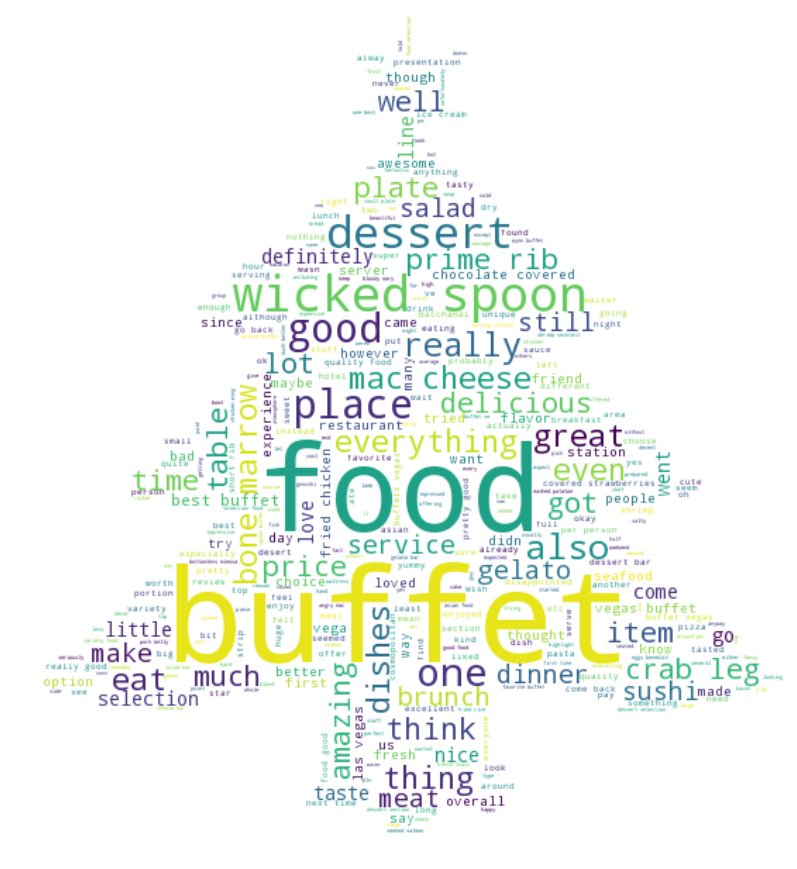

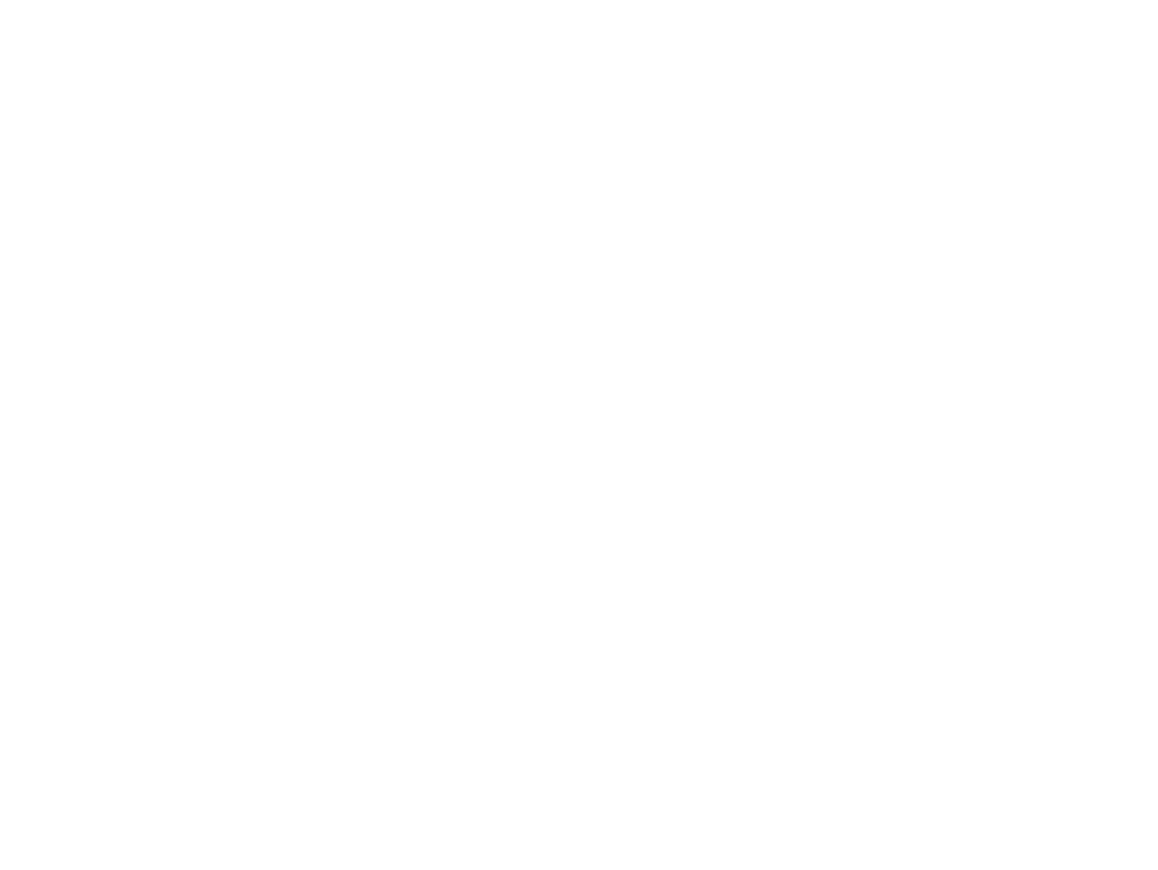

In [30]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
#text = open('alice.txt').read()
text = " ".join(biz_list) #read in review text

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open("tree5.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white",width=2000, height=1000,  max_words=1000, mask=alice_mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(text)

# store to file
wc.to_file("alice.png")

# show
plt.figure(figsize=(20, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20, 15))
plt.axis("off")
plt.show()